### Import Data from Kaggle

In [ ]:
# mount to the Google Drive to access the uploaded 'kaggle.json' file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install kaggle
!pip install kaggle

In [ ]:
# configure the kaggle API access
# create a directory for kaggle in the Colab environment
# copy the kaggle.json file from the Google Drive
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
# set permission to the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the dataset using the kaggle API command
!kaggle datasets download gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 735M/736M [00:39<00:00, 17.1MB/s]
100% 736M/736M [00:39<00:00, 19.6MB/s]


In [ ]:
# unzip the download dataset
!unzip eye-diseases-classification.zip

Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_l

### Import Essential Libraries

In [ ]:
# import essential libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

### Data Augmentation

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/eye_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/dataset/eye_val.csv')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 0.3,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
)

val_datagen = ImageDataGenerator(
)

In [ ]:
# prepare the dataset
# perform data augmentationon training data
train_ds = train_datagen.flow_from_dataframe(
    directory = None,
    dataframe = train_df,
    x_col = 'Path',
    y_col = 'Labels',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (224, 224),
    shuffle = True,
    seed = 122
)

val_ds = val_datagen.flow_from_dataframe(
    directory = None,
    dataframe = val_df,
    x_col = 'Path',
    y_col = 'Labels',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (224, 224),
    shuffle = False,
    seed = 122
)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


### Transfer Learning

In [ ]:
# metrics to be used for compiling the model
metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# helper function to define the neural network on top of the pre-trained model
def tf_model():
  input_shape = (224, 224, 3)

  base_model = keras.applications.EfficientNetB3(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape
    )

  base_model.trainable = True

  x = base_model.output
  x = tf.keras.layers.Rescaling(1./255)(x)
  x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dense(units=128, activation='relu')(x)
  x = layers.Dropout(rate=0.2, seed=122)(x)
  output = layers.Dense(units=4, activation='softmax')(x)

  model = keras.models.Model(inputs=base_model.inputs, outputs=output)

  model.compile(optimizer = keras.optimizers.Adamax(learning_rate=0.001),
                loss = keras.losses.categorical_crossentropy,
                metrics = metrics)

  return model

In [ ]:
# create the neural network
enet = tf_model()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# define list of callbacks to enhance model training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/models/enetb3.keras', save_best_only=True),
    keras.callbacks.CSVLogger(filename='/content/drive/MyDrive/learning_history/enetb3.csv'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001)
    ]

In [ ]:
# fit the model with the training dataset
history_enet = enet.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - auc: 0.8749 - categorical_accuracy: 0.6800 - loss: 0.8742 - precision: 0.8062 - recall: 0.4173 - val_auc: 0.7233 - val_categorical_accuracy: 0.4660 - val_loss: 1.2916 - val_precision: 1.0000 - val_recall: 0.0079 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 672ms/step - auc: 0.9816 - categorical_accuracy: 0.8958 - loss: 0.3120 - precision: 0.9042 - recall: 0.8851 - val_auc: 0.7992 - val_categorical_accuracy: 0.6445 - val_loss: 1.1250 - val_precision: 1.0000 - val_recall: 0.1548 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 87s 719ms/step - auc: 0.9882 - categorical_accuracy: 0.9125 - loss: 0.2439 - precision: 0.9211 - recall: 0.9037 - val_auc: 0.8677 - val_categorical_accuracy: 0.6809 - val_loss: 0.9428 - val_precision: 0.9624 - val_recall: 0.4044 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 672ms/step - auc: 0.9939 - categorical_accuracy: 0.9354 - loss: 0.1789 - precision: 0.9404 - re

In [ ]:
# model summary
enet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 33,468,941 (127.67 MB)

 Trainable params: 11,126,188 (42.44 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,252,378 (84.89 MB)

In [ ]:
# helper function to visualize the learning curves
def plot_curves(train_acc, val_acc, train_loss, val_loss):
  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.plot(train_acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(train_loss, label='Training')
  plt.plot(val_loss, label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper left')
  plt.title('Loss')
  plt.grid()

  plt.show()

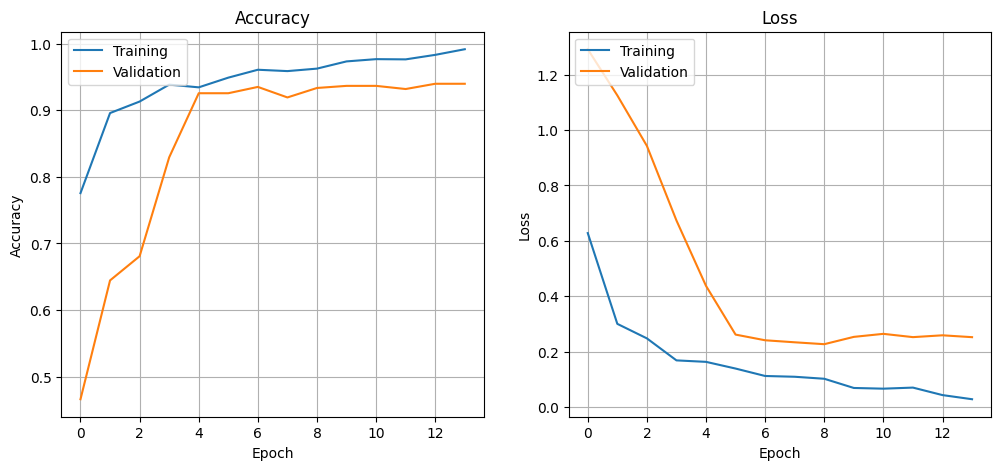

In [ ]:
# visualize the learning curves
enet_train_acc = history_enet.history['categorical_accuracy']
enet_train_loss = history_enet.history['loss']
enet_val_acc = history_enet.history['val_categorical_accuracy']
enet_val_loss = history_enet.history['val_loss']

plot_curves(enet_train_acc, enet_val_acc, enet_train_loss, enet_val_loss)

In [ ]:
# save the trained model
enet.save('/content/drive/MyDrive/models/enetb3.h5')